# Generate paleogeographic reconstructions for Laurentia tectonics associated with SWLLIP

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
import matplotlib.patches as patches
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

# pmagpy
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import cartopy.crs as ccrs
import cartopy
import cartopy.io.shapereader as shpreader
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import xml.etree.ElementTree as ET
import pygplates as pgp

# from paleogeo_functions import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def make_reconstructured_shapefile(gpml_file,rotation_file,reconstruction_time,anchor_plate,file_export_path_prefix):

    rotation_model = pgp.RotationModel(rotation_file)
    features = pgp.FeatureCollection(gpml_file)
    export_filename = file_export_path_prefix + '{0}Ma.shp'.format(reconstruction_time)
    pgp.reconstruct(features, rotation_model, export_filename, reconstruction_time, anchor_plate)

    fname = export_filename
    reconstructed_feature = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), edgecolor='C0',linewidth=3,facecolor='none')
    return reconstructed_feature

In [3]:
def get_craton_XYs(gpml, plateIDs):
    """
    Get XY coordinates of a plate polygon from a .gpml.
    
    Parameters
    ----------
    gpml : string
        Path to .gpml file.
        
    plateIDs : list
        Of plateIDs.
    """
    # namespace dictionary
    ns = {'gpml':'http://www.gplates.org/gplates',
          'gml':'http://www.opengis.net/gml'}
    
    # initial parse
    tree = ET.parse(gpml)
    root = tree.getroot()
    
    # storage
    Xs = []
    Ys = []
    
    # iterate through featureMembers
    for featureMember in root.findall('gml:featureMember',ns):
        
        # get child
        for child in featureMember:
            slice_ind = child.tag.find('}')
            child_root = 'gpml:' + child.tag[slice_ind+1:]
        
        # check plateID
        plateID_path = child_root + '/gpml:reconstructionPlateId/gpml:ConstantValue/gpml:value'
        feature_plateID = int(featureMember.find(plateID_path,ns).text)
        if feature_plateID in plateIDs:
            
            if featureMember.find(child_root + '/gpml:outlineOf', ns)!=None:
                polygon_root = child_root + '/gpml:outlineOf'
            elif featureMember.find(child_root + '/gpml:boundary', ns)!=None:
                polygon_root = child_root + '/gpml:boundary'
            elif featureMember.find(child_root + '/gpml:unclassifiedGeometry', ns)!=None:
                polygon_root = child_root + '/gpml:unclassifiedGeometry'
            elif featureMember.find(child_root + '/gpml:centerLineOf', ns)!=None:
                polygon_root = child_root + '/gpml:centerLineOf'
            else:
                raise Exception('polygon_root undefined.')
            
            # get coordinates
            posList_path = polygon_root + '/gpml:ConstantValue/gpml:value/gml:Polygon/gml:exterior/gml:LinearRing/gml:posList'
            for feature_posList in featureMember.findall(posList_path,ns):
                np_posList = np.fromstring(feature_posList.text, dtype=float, sep=' ')
            
                # split into lat and lon
                lat_inds = np.arange(0, len(np_posList), 2, dtype=int)
                lon_inds = np.arange(1, len(np_posList), 2, dtype=int)

                feature_lat = np_posList[lat_inds]
                feature_lon = np_posList[lon_inds]
            
                Xs.append(feature_lon)
                Ys.append(feature_lat)
            
    return Xs, Ys
    
def craton_plot(ax, plateIDs, Eulers, edgecolor, facecolor, alpha, linewidth, gpml = '../GPlates/Cratons/shapes_cratons.gpml', reverse_draw=False,draw_face=True,draw_edge=True):
    """
    Plot cratons with rotation.
    
    Parameters
    ----------
    ax : map axis
        On which to plot.
    
    plateIDs : list
        Of plateIDs.
        
    Eulers : list of lists
        Of Euler rotation parameters - if more than one given,
        the rotations will be additive.
    """
    # get cratons from .gpml
    
    Xs, Ys = get_craton_XYs(gpml, plateIDs)
    
    # draw in reverse
    if reverse_draw:
        Xs = np.flip(Xs)
        Ys = np.flip(Ys)
    
    # rotate cratons
    rotated_Xs = []
    rotated_Ys = []
    for i in range(len(Xs)):
        rotated_X = np.array([])
        rotated_Y = np.array([])
        for j in range(len(Xs[i])):
            this_X = [Xs[i][j]]
            this_Y = [Ys[i][j]]
            for k in range(len(Eulers)):
                this_Y, this_X = pmag.pt_rot(Eulers[k], this_Y, this_X)
            rotated_X = np.append(rotated_X, this_X)
            rotated_Y = np.append(rotated_Y, this_Y)
        rotated_Xs.append(rotated_X)
        rotated_Ys.append(rotated_Y)
        
    # add cratons
    for i in range(len(rotated_Xs)):
        XY = np.stack([rotated_Xs[i][::-1],rotated_Ys[i][::-1]],axis=1)
        if draw_edge:
            poly_edge = patches.Polygon(XY,
                                        edgecolor=edgecolor,facecolor='none',alpha=alpha,
                                        transform=ccrs.Geodetic(), linewidth=linewidth)
            ax.add_patch(poly_edge)
        if draw_face:
            poly_face = patches.Polygon(XY,
                                        edgecolor='none',facecolor=facecolor,alpha=alpha,
                                        transform=ccrs.Geodetic())
            ax.add_patch(poly_face)

def equi_filled(map_axis, centerlon, centerlat, radius, color, alpha=1.0, edge_alpha=1.0):
    """
    Modified from the ipmag function equi().
    """
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = ipmag.shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
    
    X = X[::-1]
    Y = Y[::-1]
    
    XY = np.stack([X,Y],axis=1)
    
    circle_edge = patches.Polygon(XY,
                                  edgecolor=color,facecolor='none',alpha=edge_alpha,
                                  transform=ccrs.Geodetic())
    circle_face = patches.Polygon(XY,
                                  edgecolor='none',facecolor=color,alpha=alpha,
                                  transform=ccrs.Geodetic())
    
    map_axis.add_patch(circle_face)
    map_axis.add_patch(circle_edge)
    
def rotated_pole_plot(ax, plon, plat, a95, Eulers, marker, s, marker_color, a95_color, a95_alpha, a95_edge_alpha=1.0):
    """
    Plot paleomagnetic pole with rotation.
    """
    # rotate pole
    rotated_plat = plat
    rotated_plon = plon
    for i in range(len(Eulers)):
        rotated_plat, rotated_plon = pmag.pt_rot(Eulers[i], [rotated_plat], [rotated_plon])
        rotated_plat = rotated_plat[0]
        rotated_plon = rotated_plon[0]
    
    # degrees to km conversion
    a95_km = a95 * 111.32
    
    # pole
    ax.scatter(rotated_plon, rotated_plat, marker=marker,
               color=marker_color, edgecolors='k', s=s,
               label='__nolegend__', zorder=101, transform=ccrs.PlateCarree())
    
    # a95
    equi_filled(ax, rotated_plon, rotated_plat, a95_km, a95_color, alpha=a95_alpha, edge_alpha=a95_edge_alpha)

## Define reconstruction style

In [4]:
Laurentia_color = '#feb5b1'
Scotland_color = 'lightgray'
Baltica_color = 'lightgray'

Australia_color = 'lightgray'
Antarctica_color = 'lightgray'
Zealandia_color = 'lightgray'

Siberia_color = 'lightgray'

NorthChina_color = 'lightgray'
Tarim_color = 'lightgray'

Kalahari_color = 'lightgray'

Amazonia_color = 'lightgray'
RDLP_color = 'lightgray'
Arequipa_color = 'lightgray'

lat_grid = [-80,-60,-30,0,30,60,80]
lon_grid = np.arange(-180,180+60,60)

cratons_lw = 1.0
outline_lw = 0.25
cratons_alpha = 1.0

Origin of shapes used in shapes_cratons.gpml
- Laurentia and parauthothons are from Torsvik and Cocks and are then edited to match the southern Laurentia margin of Whitmeyer and Karlstrom. The Roberts Mountain Block of Torsvik and Cocks is pruned in to match the Proterozoic Laurentia for Whitmeyer and Karlstrom as well.
- Siberia (401) is the 401 Siberia of Torsvik and Cocks trimmed to match the extent of craton used in Merdith et al. 2021
- Siberia (404) is the Aldan of Torsvik and Cocks trimmed to not have extra part of Anabar
- Tarim is from Torsvik and Cocks (2017)
- North China is shape used in Ding
- Baltica is Torsvik and Cocks (2017) polygon
- Zealandia is a rough sketch based on Turnbull et al. 2021
- Arequipa polygon is from Blake Hodgin

## Define rotation parameters

In [5]:
Laur_Parauto_Euler = [71.87,97.94,-2.0] #Torsvik and Cocks (2017)
Greenland_Laur_Euler = [67.5,-118.5,-13.8] #Roest and Srivastava (1989)

Arctic_Euler = [57.15,-137.0,-1.07] #block 120 (Sverdrup Basin/Canadian Arctic Island) Gion et al. 2016
W_Ellesmere_Euler = [76.6,-89.13,-1.55] #block 124 (West Ellesmere) > block 120 Gion et al. 2016
WC_Ellesmere_Euler = [-0.21,-133.96,-0.39] #block 123 (West-Central Ellesmere) > block 124 Gion et al. 2016
EC_Ellesmere_Euler = [-70.27,-154.4,-0.98] #block 122 (East-Central Ellesmere) > block 123 Gion et al. 2016
E_Ellesmere_Euler = [58.12,-104.43,-1.86] #block 121 (East Ellesmere) > block 122 Gion et al. 2016
NorthSlope_Euler = [71.5,-126,-102] #North Slope terrane

Svalbard_Laur_Euler = [-81.0,125.0,68.0]
Scotland_Laur_Euler = [78.64,161.9,-32.0]

def plot_Laurentia(ax, Laur_Euler):
    # Laurentia
    craton_plot(ax, [101], [Laur_Euler],
                'k', Laurentia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    craton_plot(ax, [101], [Laur_Euler],
            'k', Laurentia_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/CEED6_LAND_select.gpml',draw_face=False)
    craton_plot(ax, [153], [Laur_Euler],
                'k', Laurentia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    craton_plot(ax, [162], [Laur_Euler],
                'k', Laurentia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')

    # Greenland
    craton_plot(ax, [102], [Greenland_Laur_Euler, Laur_Euler],
                'k', Laurentia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    craton_plot(ax, [102], [Greenland_Laur_Euler, Laur_Euler],
            'k', Laurentia_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/CEED6_LAND_select.gpml',draw_face=False)
    
    # Arctic Islands
    craton_plot(ax, [120], [Arctic_Euler, Laur_Euler],
                'k', Laurentia_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/Gion2016_Coastlines_noPearya.gpml')
    craton_plot(ax, [124], [W_Ellesmere_Euler, Arctic_Euler, Laur_Euler],
                'k', Laurentia_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/Gion2016_Coastlines_noPearya.gpml')
    craton_plot(ax, [123], [WC_Ellesmere_Euler, W_Ellesmere_Euler, Arctic_Euler, Laur_Euler],
                'k', Laurentia_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/Gion2016_Coastlines_noPearya.gpml')
    craton_plot(ax, [122], [EC_Ellesmere_Euler, WC_Ellesmere_Euler, W_Ellesmere_Euler, Arctic_Euler, Laur_Euler],
                'k', Laurentia_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/Gion2016_Coastlines_noPearya.gpml')
    craton_plot(ax, [121], [E_Ellesmere_Euler,EC_Ellesmere_Euler, WC_Ellesmere_Euler, W_Ellesmere_Euler, Arctic_Euler, Laur_Euler],
                'k', Laurentia_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/Gion2016_Coastlines_noPearya.gpml')
    craton_plot(ax, [1031], [NorthSlope_Euler, Laur_Euler],
                'k', Laurentia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/NorthSlope_small.gpml')

    
    # Scotland
    craton_plot(ax, [303], [Scotland_Laur_Euler, Laur_Euler],
            'k', Scotland_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    craton_plot(ax, [303], [Scotland_Laur_Euler, Laur_Euler],
            'k', Scotland_color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/CEED6_LAND_select.gpml',draw_face=False)

Siberia_Laur_Euler = [75.2664,96.6369,130.1723] #Modified Euler that still honors poles, but doesn't cause overlap with Arctic Islands
Viljay_Rift_Euler = [60.0,100.0,14.0] #Aldan (404) to Anabar (401) rotation of Torsvik and Cocks 2017

def plot_Siberia(ax, Laur_Euler):
    craton_plot(ax, [401], [Siberia_Laur_Euler, Laur_Euler],
                'k', Siberia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    craton_plot(ax, [404], [Viljay_Rift_Euler, Siberia_Laur_Euler, Laur_Euler],
                'k', Siberia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')


NChina_Laur_Euler = [56.0735,19.208,68.0042]

def plot_North_China(ax, Laur_Euler):
    #North China
    # craton_plot(ax, [601], [NChina_Laur_Euler, Laur_Euler],
    #             'k', NorthChina_color, cratons_alpha, cratons_lw, gpml='CEED6-modified.gpml')
    craton_plot(ax, [601], [NChina_Laur_Euler, Laur_Euler],
                'k', NorthChina_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=True)

Tarim_Laur_Euler = [74,340,124] #Ding et al. 2021 modification of Wen model

SAus_Laur_Euler = [-35.4124,-32.1725,-128.5807]
NAus_SAus_Euler = [-20.0,135.0,-40.0]
Antarctica_SAus_Euler = [-3.91,37.9,30.86]
def plot_Australia(ax, Laur_Euler):
    craton_plot(ax, [801], [SAus_Laur_Euler, Laur_Euler],
                'k', Australia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=True)
    craton_plot(ax, [8011], [NAus_SAus_Euler, SAus_Laur_Euler, Laur_Euler],
                'k', Australia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=True)
    craton_plot(ax, [802], [Antarctica_SAus_Euler, SAus_Laur_Euler, Laur_Euler],
                'k', Antarctica_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    
Zealandia_Laur_Euler = [22.1,151.6,116.6]
def plot_Zealandia(ax, Laur_Euler):
    craton_plot(ax, [8060], [Zealandia_Laur_Euler, Laur_Euler],
                'k', Zealandia_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=False)
    
    
Tarim_Laur_Euler = [-72,170,-122]
def plot_Tarim(ax, Laur_Euler):
    craton_plot(ax, [480], [Tarim_Laur_Euler, Laur_Euler],
                'k', Tarim_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=False)

Parana_Amazonia_Euler = [0.67,103.22,-30.82]

Arequipa_Antofalla_Euler = [-16.17,-68.14,-17.12]
Antofalla_Laur_Euler = [11.7727,-52.3764,-100.4464]
Pampia_Antofalla_Euler = [90.0,0.0,0.0]
def plot_AREPA(ax, Laur_Euler):
    craton_plot(ax, [20110], [Arequipa_Antofalla_Euler,Antofalla_Laur_Euler, Laur_Euler],
                'k', Arequipa_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    craton_plot(ax, [20111], [Antofalla_Laur_Euler, Laur_Euler],
                'k', Arequipa_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    craton_plot(ax, [2902], [Pampia_Antofalla_Euler,Antofalla_Laur_Euler, Laur_Euler],
                'k', Arequipa_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')
    
    
Cuyania_Laur_Euler = [0.4682,95.7669,186.7944]
def plot_Cuyania(ax, Laur_Euler):
    craton_plot(ax, [2901], [Cuyania_Laur_Euler, Laur_Euler],
                'k', Arequipa_color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')

India_Euler_755 = [65.4126,103.9231,-29.3572]
SChina_India_Euler = [6.7224,77.6921,67.9571]
Rayner_India_Euler = [1.8434,-165.1696,-91.8395]

## Load Gplates reconstruction file

In [12]:
input_rotation_filename = '../data/models_shapes/TC2017-SHM2017-D2018-extended.rot'
rotation_model = pgp.RotationModel(input_rotation_filename)
fixed_plate = 1 # Indo-atlantic hotspot frame

## get Euler parameters for Laurentia at ca. 1098 Ma

In [13]:
Laurentia = 101
Baltica = 302
Amazonia = 201
Kalahari = 7011
RLDP = 203

reconstruction_time = 1098

Laurentia_rotation_1098 = rotation_model.get_rotation(reconstruction_time, Laurentia, 0, fixed_plate)
Laur_Euler_lat_1098, Laur_Euler_lon_1098, Laur_Euler_angle_1098 = Laurentia_rotation_1098.get_lat_lon_euler_pole_and_angle_degrees()
Laur_Euler_1098 = [Laur_Euler_lat_1098, Laur_Euler_lon_1098, Laur_Euler_angle_1098]

## ca. 1098 Ma paleogeography

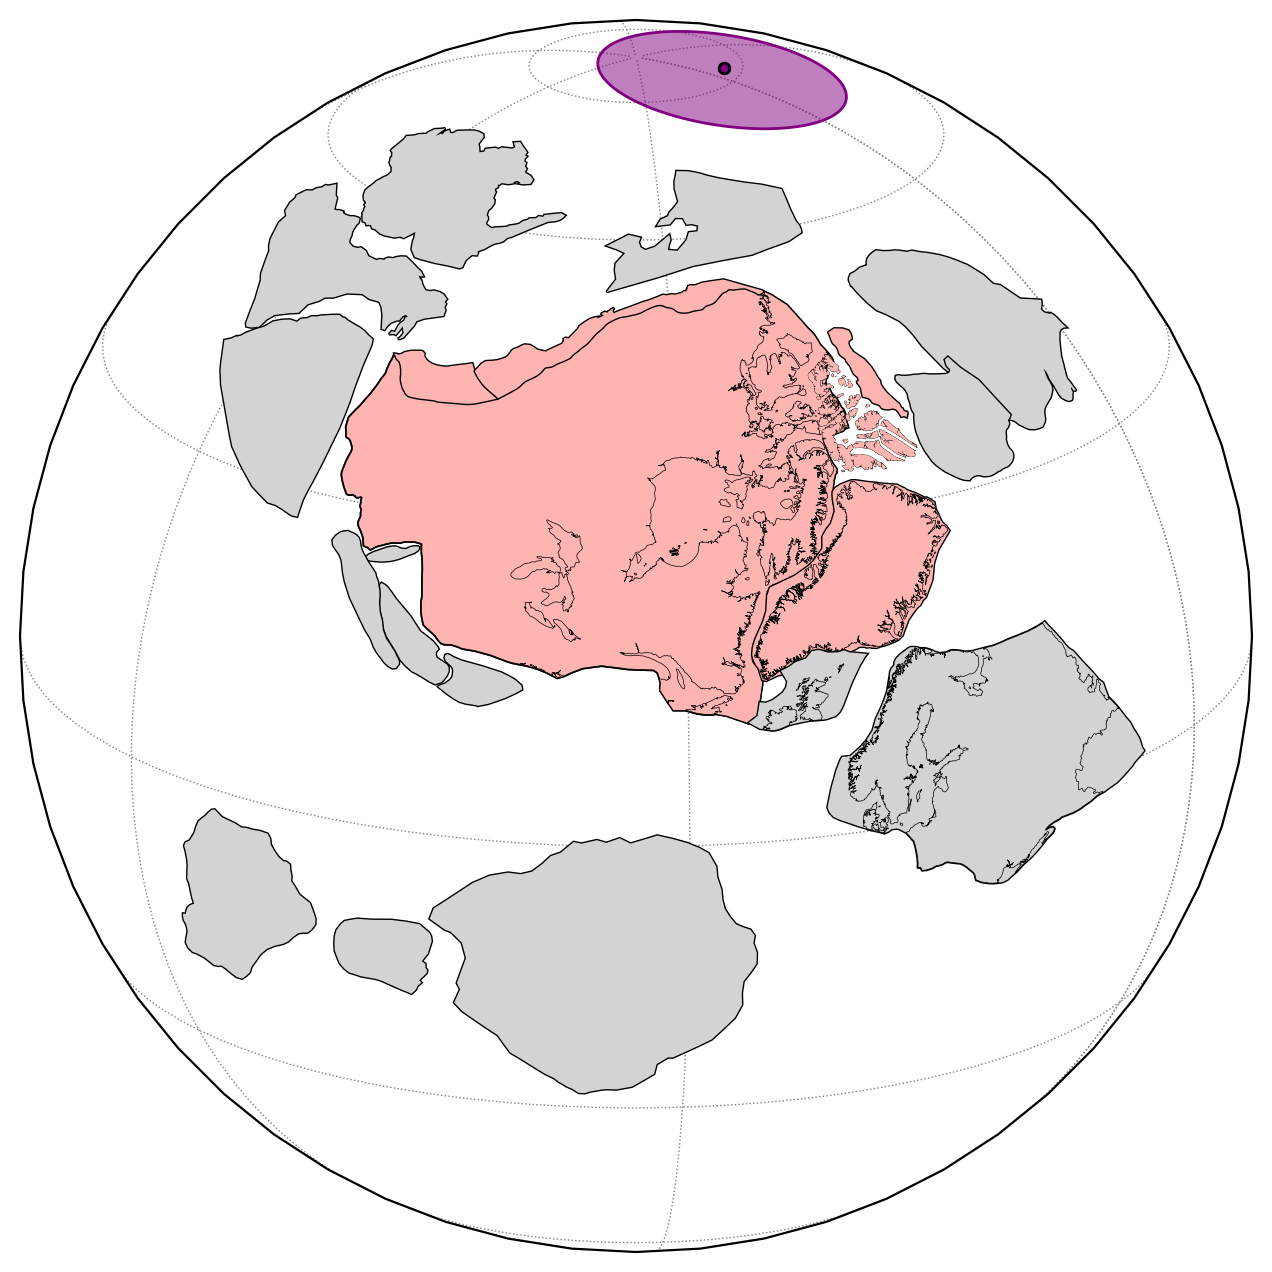

In [14]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=20,
                                 figsize=(8,8), grid_lines=False)

for craton, color in zip([Laurentia, Baltica, Amazonia, Kalahari, RLDP], 
                         [Laurentia_color, Baltica_color, Amazonia_color, Kalahari_color, RDLP_color]):
    craton_rotation = rotation_model.get_rotation(reconstruction_time, craton, 0, fixed_plate)
    craton_Euler_lat, craton_Euler_lon, craton_Euler_angle = craton_rotation.get_lat_lon_euler_pole_and_angle_degrees()
    this_Euler = [craton_Euler_lat, craton_Euler_lon, craton_Euler_angle] # Euler pole for this craton at this time
    
    if craton == Baltica:
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=False)
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/CEED6_LAND_select.gpml',draw_face=False)
    elif (craton == Amazonia) or (craton == Kalahari):
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=True)
    elif (craton == RLDP):
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=False)
    else: 
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')

plot_Laurentia(ax,Laur_Euler_1098)
plot_Siberia(ax,Laur_Euler_1098)
plot_North_China(ax,Laur_Euler_1098)
plot_Australia(ax,Laur_Euler_1098)
plot_Cuyania(ax, Laur_Euler_1098)
plot_AREPA(ax, Laur_Euler_1098)

# set gridlines
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)

# plot the ca. 1098 Ma Death Valley pole
rotated_pole_plot(ax, 176.6, 44.9, 11.8,
                  [Laur_Euler_1098],
                  'o', 15, marker_color='purple', a95_color='purple', a95_alpha=0.5)

plt.savefig('./code_output/Laurentia_1098.pdf', bbox_inches='tight')
plt.show()

## get Euler parameters for Laurentia at ca. 1082 Ma

In [20]:
reconstruction_time = 1082

Laurentia_rotation_1082 = rotation_model.get_rotation(reconstruction_time, Laurentia, 0, fixed_plate)
Laur_Euler_lat_1082, Laur_Euler_lon_1082, Laur_Euler_angle_1082 = Laurentia_rotation_1082.get_lat_lon_euler_pole_and_angle_degrees()
Laur_Euler_1082 = [Laur_Euler_lat_1082, Laur_Euler_lon_1082, Laur_Euler_angle_1082]

## ca. 1082 Ma paleogeography

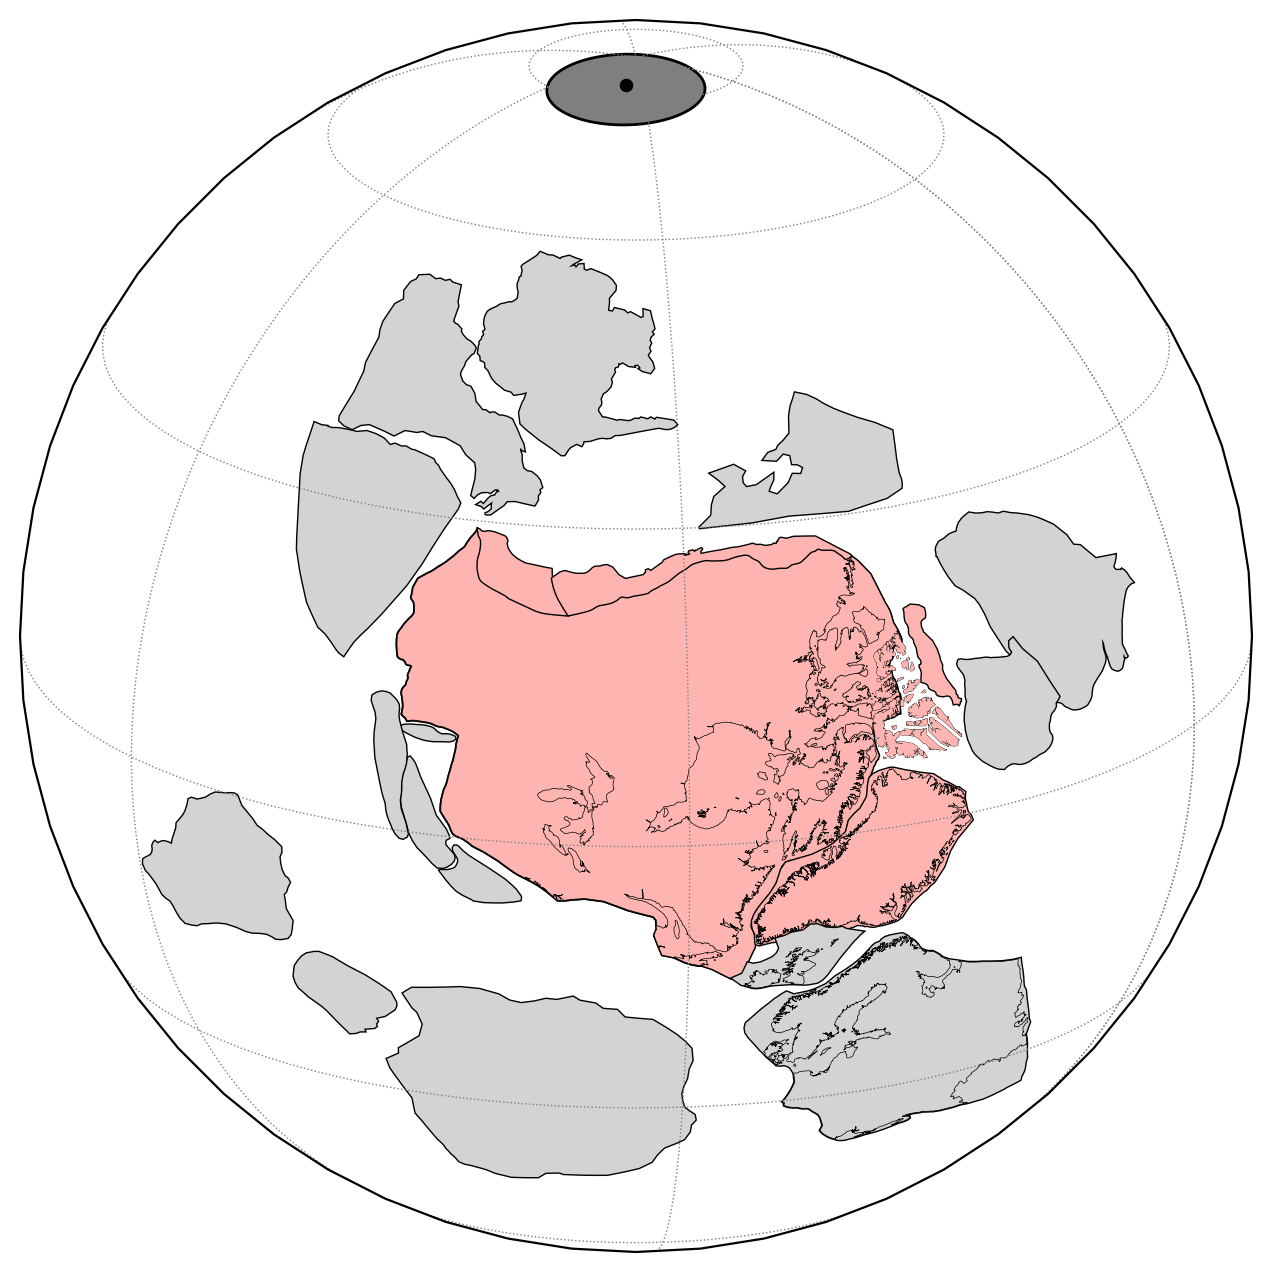

In [21]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=20,
                                 figsize=(8,8), grid_lines=False)

for craton, color in zip([Laurentia, Baltica, Amazonia, Kalahari, RLDP], 
                         [Laurentia_color, Baltica_color, Amazonia_color, Kalahari_color, RDLP_color]):
    craton_rotation = rotation_model.get_rotation(reconstruction_time, craton, 0, fixed_plate)
    craton_Euler_lat, craton_Euler_lon, craton_Euler_angle = craton_rotation.get_lat_lon_euler_pole_and_angle_degrees()
    this_Euler = [craton_Euler_lat, craton_Euler_lon, craton_Euler_angle] # Euler pole for this craton at this time
    
    if craton == Baltica:
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=False)
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, outline_lw, gpml='../Data/models_shapes/CEED6_LAND_select.gpml',draw_face=False)
    elif (craton == Amazonia) or (craton == Kalahari):
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=True)
    elif (craton == RLDP):
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml', reverse_draw=False)
    else: 
        craton_plot(ax, [craton], [this_Euler],
                'k', color, cratons_alpha, cratons_lw, gpml='../Data/models_shapes/shapes_cratons.gpml')

plot_Laurentia(ax,Laur_Euler_1082)
plot_Siberia(ax,Laur_Euler_1082)
plot_North_China(ax,Laur_Euler_1082)
plot_Australia(ax,Laur_Euler_1082)
plot_Cuyania(ax, Laur_Euler_1082)
plot_AREPA(ax, Laur_Euler_1082)

# set gridlines
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)

# plot the ca. 1082 Ma Cardenas Basalt pole
rotated_pole_plot(ax, 183.9, 15.9, 7.4,
             [Laur_Euler_1082],
             'o', 15, marker_color='k', a95_color='k', a95_alpha=0.5)

plt.savefig('./code_output/Laurentia_1082.pdf', bbox_inches='tight')
plt.show()